# 

In [2]:
import torch
import stable_baselines3
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import control as ct
from control import matlab
from scipy.signal import tf2zpk, zpk2tf, cont2discrete, TransferFunction
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from scipy.spatial.transform import Rotation as R

print("python version:", sys.version)
print("stable_baselines3 version:", stable_baselines3.__version__)
print("torch version:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda version:", torch.version.cuda)
print("cudnn version:", torch.backends.cudnn.version())


## 

python version: 3.12.1 | packaged by conda-forge | (main, Dec 23 2023, 07:53:56) [MSC v.1937 64 bit (AMD64)]
stable_baselines3 version: 2.2.1
torch version: 2.2.0
cuda available: True
cuda version: 12.1
cudnn version: 8801


# 4th order transfer function

In [33]:
class VSQP_TF_4th:
    def __init__(self,
                 num_envs,
                 start_pos, 
                 time_step):

        self.pos = start_pos
        # self.states = np.array([self.random_init() for _ in range(num_envs)])
        self.dt  = time_step   
        self.updated_states_drone = np.zeros(9)
        self.num_envs = num_envs
        self.ax_lim = np.array([1,1,1])
        self.buffer_size = 4
        # self.updated_states = np.zeros_like(self.states)
        self.past_actions  = np.zeros((num_envs,self.buffer_size,3))

    def add_action(self, new_action):
         # Add the new action at the end of the buffer if there is space
        if self.past_actions.shape[1] < self.buffer_size:
            self.past_actions = np.append(self.past_actions, new_action[:, None, :], axis=1)
        else:
            # If buffer is full, remove the oldest (first) action and append the new action at the end
            self.past_actions = np.roll(self.past_actions, -1, axis=1)
            self.past_actions[:, -1, :] = new_action



    def acc_differentiation(self, actions):

        # self.past_actions = np.roll(self.past_actions, -1, axis=0)
        # self.past_actions[-1, :] = actions
        if self.past_actions.shape[1] < self.buffer_size:
            self.past_actions = np.append(self.past_actions, actions[:, None, :], axis=1)
        else:
            # If buffer is full, remove the oldest (first) action and append the new action at the end
            self.past_actions = np.roll(self.past_actions, -1, axis=1)
            self.past_actions[:, -1, :] = actions

        # Compute the first, second, and third derivatives of the actions using finite differences
        jerk = (self.past_actions[:, -1, :] - self.past_actions[:, -2, :]) / self.dt
        snap = (self.past_actions[:, -1, :] - 2 * self.past_actions[:, -2, :] + self.past_actions[:, -3, :]) / self.dt**2
        crackle = (self.past_actions[:, -1, :]- 3 * self.past_actions[:, -2, :] + 3 * self.past_actions[:, -3, :] - self.past_actions[:, -4, :]) / self.dt**3

        return jerk, snap, crackle


    def update(self, states, actions):
        # do not keep track of the updated states in this class
        # assume that max accelearions are in between -3 and 3
        ## de-normalize the acceleration
        # denorm_ax = (actions[:,0] + 1)/2*(self.ax_lim[0] + self.ax_lim[0]) - self.ax_lim[0]
        # denorm_ay = (actions[:,1] + 1)/2*(self.ax_lim[1] + self.ax_lim[1]) - self.ax_lim[1]
        # denorm_az = (actions[:,2] + 1)/2*(self.ax_lim[2] + self.ax_lim[2]) - self.ax_lim[2]
        # de_acc = np.stack([actions[:,0], actions[:,1], actions[:,2]]).T
        de_acc = np.stack([actions[0], actions[1], actions[2]]).T

        # call differentiation to calculate the acc derivatives
        der1_acc, der2_acc, der3_acc = self.acc_differentiation(actions)
        der1_acc = der1_acc.reshape(1,3)
        der2_acc = der2_acc.reshape(1,3)
        der3_acc = der3_acc.reshape(1,3)
        de_acc = de_acc.reshape(1,3)


        # Anorth and Aeast
        der6_Y_ne = 793*de_acc[:,0:2] + 203.6*der1_acc[:,0:2] + 0.0008596*der2_acc[:,0:2] + -9.477*10**-7*der3_acc[:,0:2] - 19.89*states[:,15:17] - 139.5* states[:,12:14] - 633.2*states[:,9:11] - 793.2*states[:,6:8]
        # der6_Y_d = 318.9*de_acc[:,2] + 956.8*der1_acc[:,2] + 2870*der2_acc[:,2] + 678.6*der3_acc[:,2] - 24.42*states[:,23] - 223.6*states[:,20] - 1157*states[:,17] - 3030* states[:,14] - 1010*states[:,11] - 318.9*states[:,8]
        der6_Y_d =793*de_acc[:,2] + 203.6*der1_acc[:,2] + 0.0008596*der2_acc[:,2] + -9.477*10**-7*der3_acc[:,2] - 19.89*states[:,17] - 139.5* states[:,14] - 633.2*states[:,11] - 793.2*states[:,8]
        # der6_Y_d_reshape = der6_Y_d.reshape(1,-1)
        # combine both derivatives - use tf of the ne
        der4_Acc = np.column_stack((der6_Y_ne, der6_Y_d))
        # assume derivatives of u are zero
        updated_pos = states[:,0:3] + states[:,3:6]*self.dt
        updated_vel = states[:,3:6] + states[:,6:9]*self.dt
        updated_acc = states[:,6:9] + states[:,9:12]*self.dt # real acceleration response of the ac
        der_1 = states[:,9:12] + states[:,12:15]*self.dt
        der_2 = states[:,12:15] + states[:,15:18]*self.dt
        der_3 = states[:,15:18] + der4_Acc*self.dt

        return updated_pos, updated_vel, updated_acc, der_1, der_2, der_3
    
    def reset_(self,num_reset):

        x0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[0]
        y0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[1]
        z0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[2]
        
        vx0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vy0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vz0 = np.random.uniform(-0.5,0.5, size=(num_reset,))

        ax0 = np.random.uniform(-0.05,0.05, size=(num_reset,))
        ay0 = np.random.uniform(-0.05,0.05, size=(num_reset,))
        az0 = np.random.uniform(-0.05,0.05, size=(num_reset,))


        # Create an array of zeros with the shape (num_reset, 15) for the additional derivatives + 3 for the derivatives of accelerations
        zero_der_array = np.zeros((num_reset, 9))

        # Group them in threes (position, velocity, acceleration)
        # zero initial conditions
        positions = np.stack((x0, y0, z0), axis=-1)
        velocities = np.stack((vx0, vy0, vz0), axis=-1)
        accelerations = np.stack((ax0, ay0, az0), axis=-1)
        # Now, stack these groups along with the zero array to form the final state array
        stacked_states = np.hstack((positions, velocities, accelerations, zero_der_array))

        # modify it in a way that it includes the derivatives(zero given)
        # stacked_states = np.stack([x0, y0, z0, vx0, vy0, vz0,ax0, ay0, az0, zero_der_array ]).T
        return stacked_states

# 6th order transfer function

In [27]:
class VSQP_TF_6th:
    def __init__(self,
                 num_envs,
                 start_pos, 
                 time_step):

        self.pos = start_pos
        # self.states = np.array([self.random_init() for _ in range(num_envs)])
        self.dt  = time_step   
        self.updated_states_drone = np.zeros(9)
        self.num_envs = num_envs
        self.ax_lim = np.array([1,1,1])
        self.buffer_size = 4
        # self.updated_states = np.zeros_like(self.states)
        self.past_actions  = np.zeros((num_envs,self.buffer_size,3))

    def add_action(self, new_action):
         # Add the new action at the end of the buffer if there is space
        if self.past_actions.shape[1] < self.buffer_size:
            self.past_actions = np.append(self.past_actions, new_action[:, None, :], axis=1)
        else:
            # If buffer is full, remove the oldest (first) action and append the new action at the end
            self.past_actions = np.roll(self.past_actions, -1, axis=1)
            self.past_actions[:, -1, :] = new_action



    def acc_differentiation(self, actions):

        # self.past_actions = np.roll(self.past_actions, -1, axis=0)
        # self.past_actions[-1, :] = actions
        if self.past_actions.shape[1] < self.buffer_size:
            self.past_actions = np.append(self.past_actions, actions[:, None, :], axis=1)
        else:
            # If buffer is full, remove the oldest (first) action and append the new action at the end
            self.past_actions = np.roll(self.past_actions, -1, axis=1)
            self.past_actions[:, -1, :] = actions

        # Compute the first, second, and third derivatives of the actions using finite differences
        jerk = (self.past_actions[:, -1, :] - self.past_actions[:, -2, :]) / self.dt
        snap = (self.past_actions[:, -1, :] - 2 * self.past_actions[:, -2, :] + self.past_actions[:, -3, :]) / self.dt**2
        crackle = (self.past_actions[:, -1, :]- 3 * self.past_actions[:, -2, :] + 3 * self.past_actions[:, -3, :] - self.past_actions[:, -4, :]) / self.dt**3

        return jerk, snap, crackle


    def update(self, states, actions):
        # do not keep track of the updated states in this class
        # assume that max accelearions are in between -3 and 3
        ## de-normalize the acceleration
        # denorm_ax = (actions[:,0] + 1)/2*(self.ax_lim[0] + self.ax_lim[0]) - self.ax_lim[0]
        # denorm_ay = (actions[:,1] + 1)/2*(self.ax_lim[1] + self.ax_lim[1]) - self.ax_lim[1]
        # denorm_az = (actions[:,2] + 1)/2*(self.ax_lim[2] + self.ax_lim[2]) - self.ax_lim[2]
        # de_acc = np.stack([actions[:,0], actions[:,1], actions[:,2]]).T
        de_acc = np.stack([actions[0], actions[1], actions[2]]).T

        # call differentiation to calculate the acc derivatives
       
        der1_acc, der2_acc, der3_acc = self.acc_differentiation(actions)
        der1_acc = der1_acc.reshape(1,3)
        der2_acc = der2_acc.reshape(1,3)
        der3_acc = der3_acc.reshape(1,3)
        de_acc = de_acc.reshape(1,3)

         # Anorth and Aeast
        der6_Y_ne = 95.68*de_acc[:,0:2] + 287*der1_acc[:,0:2] + 861.1*der2_acc[:,0:2] + 203.6*der3_acc[:,0:2] - 20.22*states[:,21:23] - 146.3*states[:,18:20] - 682*states[:,15:17] - 1021* states[:,12:14] - 340.2*states[:,9:11] - 95.68*states[:,6:8]
        # der6_Y_d = 318.9*de_acc[:,2] + 956.8*der1_acc[:,2] + 2870*der2_acc[:,2] + 678.6*der3_acc[:,2] - 24.42*states[:,23] - 223.6*states[:,20] - 1157*states[:,17] - 3030* states[:,14] - 1010*states[:,11] - 318.9*states[:,8]
        der6_Y_d = 95.68*de_acc[:,2] + 287*der1_acc[:,2] + 861.1*der2_acc[:,2] + 203.6*der3_acc[:,2] - 20.22*states[:,23] - 146.3*states[:,20] - 682*states[:,17] - 1021* states[:,14] - 340.2*states[:,11] - 95.68*states[:,8]



        # # Anorth and Aeast
        # der6_Y_ne = 95.68*de_acc[:,0:2] + 287*der1_acc[:,0:2] + 861.1*der2_acc[:,0:2] + 203.6*der3_acc[:,0:2] - 20.22*states[:,21:23] - 146.3*states[:,18:20] - 682*states[:,15:17] - 1021* states[:,12:14] - 340.2*states[:,9:11] - 95.68*states[:,6:8]
        # # der6_Y_d = 318.9*de_acc[:,2] + 956.8*der1_acc[:,2] + 2870*der2_acc[:,2] + 678.6*der3_acc[:,2] - 24.42*states[:,23] - 223.6*states[:,20] - 1157*states[:,17] - 3030* states[:,14] - 1010*states[:,11] - 318.9*states[:,8]
        # der6_Y_d = 95.68*de_acc[:,2] + 287*der1_acc[:,2] + 861.1*der2_acc[:,2] + 203.6*der3_acc[:,2] - 20.22*states[:,23] - 146.3*states[:,20] - 682*states[:,17] - 1021* states[:,14] - 340.2*states[:,11] - 95.68*states[:,8]
        # der6_Y_d_reshape = der6_Y_d.reshape(1,-1)
        # combine both derivatives - use tf of the ne
        der6_Acc = np.column_stack((der6_Y_ne, der6_Y_d))
        # assume derivatives of u are zero
        updated_pos = states[:,0:3] + states[:,3:6]*self.dt
        updated_vel = states[:,3:6] + states[:,6:9]*self.dt
        updated_acc = states[:,6:9] + states[:,9:12]*self.dt # real acceleration response of the ac
        der_1 = states[:,9:12] + states[:,12:15]*self.dt
        der_2 = states[:,12:15] + states[:,15:18]*self.dt
        der_3 = states[:,15:18] + states[:,18:21]*self.dt
        der_4 = states[:,18:21] + states[:,21:24]*self.dt
        der_5 = states[:,21:24] + der6_Acc*self.dt

        return updated_pos, updated_vel, updated_acc, der_1, der_2, der_3, der_4, der_5
    
    def reset_(self,num_reset):

        x0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[0]
        y0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[1]
        z0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[2]
        
        vx0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vy0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vz0 = np.random.uniform(-0.5,0.5, size=(num_reset,))

        ax0 = np.random.uniform(-0.05,0.05, size=(num_reset,))
        ay0 = np.random.uniform(-0.05,0.05, size=(num_reset,))
        az0 = np.random.uniform(-0.05,0.05, size=(num_reset,))


        # Create an array of zeros with the shape (num_reset, 15) for the additional derivatives + 3 for the derivatives of accelerations
        zero_der_array = np.zeros((num_reset, 15))

        # Group them in threes (position, velocity, acceleration)
        # zero initial conditions
        positions = np.stack((x0, y0, z0), axis=-1)
        velocities = np.stack((vx0, vy0, vz0), axis=-1)
        accelerations = np.stack((ax0, ay0, az0), axis=-1)
        # Now, stack these groups along with the zero array to form the final state array
        stacked_states = np.hstack((positions, velocities, accelerations, zero_der_array))

        # modify it in a way that it includes the derivatives(zero given)
        # stacked_states = np.stack([x0, y0, z0, vx0, vy0, vz0,ax0, ay0, az0, zero_der_array ]).T
        return stacked_states

# Class for the reduced VSQP Model (2nd order acc model)

In [5]:
class VSQP_TF_2nd:
    def __init__(self,
                 num_envs,
                 start_pos, 
                 time_step):

        self.pos = start_pos
        # self.states = np.array([self.random_init() for _ in range(num_envs)])
        self.dt  = time_step   
        self.updated_states_drone = np.zeros(9)
        self.num_envs = num_envs
        self.ax_lim = np.array([1,1,1])
        self.buffer_size = 2
        # self.updated_states = np.zeros_like(self.states)
        self.past_actions  = np.zeros((num_envs,self.buffer_size,3))

    def add_action(self, new_action):
         # Add the new action at the end of the buffer if there is space
        if self.past_actions.shape[1] < self.buffer_size:
            self.past_actions = np.append(self.past_actions, new_action[:, None, :], axis=1)
        else:
            # If buffer is full, remove the oldest (first) action and append the new action at the end
            self.past_actions = np.roll(self.past_actions, -1, axis=1)
            self.past_actions[:, -1, :] = new_action



    def acc_differentiation(self, actions):

        # self.past_actions = np.roll(self.past_actions, -1, axis=0)
        # self.past_actions[-1, :] = actions
        if self.past_actions.shape[1] < self.buffer_size:
            self.past_actions = np.append(self.past_actions, actions[:, None, :], axis=1)
        else:
            # If buffer is full, remove the oldest (first) action and append the new action at the end
            self.past_actions = np.roll(self.past_actions, -1, axis=1)
            self.past_actions[:, -1, :] = actions

        # Compute the first, second, and third derivatives of the actions using finite differences
        jerk = (self.past_actions[:, -1, :] - self.past_actions[:, -2, :]) / self.dt
        # snap = (self.past_actions[:, -1, :] - 2 * self.past_actions[:, -2, :] + self.past_actions[:, -3, :]) / self.dt**2
        # crackle = (self.past_actions[:, -1, :]- 3 * self.past_actions[:, -2, :] + 3 * self.past_actions[:, -3, :] - self.past_actions[:, -4, :]) / self.dt**3

        return jerk


    def update(self, states, actions):
        # do not keep track of the updated states in this class
        # assume that max accelearions are in between -3 and 3
        ## de-normalize the acceleration
        # denorm_ax = (actions[:,0] + 1)/2*(self.ax_lim[0] + self.ax_lim[0]) - self.ax_lim[0]
        # denorm_ay = (actions[:,1] + 1)/2*(self.ax_lim[1] + self.ax_lim[1]) - self.ax_lim[1]
        # denorm_az = (actions[:,2] + 1)/2*(self.ax_lim[2] + self.ax_lim[2]) - self.ax_lim[2]
        # u = np.stack([actions[:,0], actions[:,1], actions[:,2]]).T

        u = np.stack([actions[0], actions[1], actions[2]]).T
        # call differentiation to calculate the acc derivatives
       
        u_der1 = self.acc_differentiation(actions)

        y_der2 = u_der1*-0.58/0.76 + u*14.04/0.76 - states[:,9:12]*4.8 - states[:,6:9]*18.4

        # assume derivatives of u are zero
        updated_pos = states[:,0:3] + states[:,3:6]*self.dt
        updated_vel = states[:,3:6] + states[:,6:9]*self.dt
        y = states[:,6:9] + states[:,9:12]*self.dt # real acceleration response of the ac
        y_der1 = states[:,9:12] + y_der2*self.dt


        return updated_pos, updated_vel, y, y_der1

    def reset_(self,num_reset):

        x0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[0]
        y0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[1]
        z0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[2]
        
        vx0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vy0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vz0 = np.random.uniform(-0.5,0.5, size=(num_reset,))

        ax0 = np.random.uniform(-0.05,0.05, size=(num_reset,))
        ay0 = np.random.uniform(-0.05,0.05, size=(num_reset,))
        az0 = np.random.uniform(-0.05,0.05, size=(num_reset,))

        
        # x0 = np.random.uniform(0,0, size=(num_reset,)) + self.pos[0]
        # y0 = np.random.uniform(0,0, size=(num_reset,)) + self.pos[1]
        # z0 = np.random.uniform(0,0, size=(num_reset,)) + self.pos[2]
        
        # vx0 = np.random.uniform(0,0, size=(num_reset,))
        # vy0 = np.random.uniform(0,0, size=(num_reset,))
        # vz0 = np.random.uniform(0,0, size=(num_reset,))

        # ax0 = np.random.uniform(0,0, size=(num_reset,))
        # ay0 = np.random.uniform(0,0, size=(num_reset,))
        # az0 = np.random.uniform(0,0, size=(num_reset,))

        # Create an array of zeros with the shape (num_reset, 15) for the additional derivatives + 3 for the derivatives of accelerations
        zero_der_array = np.zeros((num_reset, 3))

        # Group them in threes (position, velocity, acceleration)
        # zero initial conditions
        positions = np.stack((x0, y0, z0), axis=-1)
        velocities = np.stack((vx0, vy0, vz0), axis=-1)
        accelerations = np.stack((ax0, ay0, az0), axis=-1)
        # Now, stack these groups along with the zero array to form the final state array
        stacked_states = np.hstack((positions, velocities, accelerations, zero_der_array))

        # modify it in a way that it includes the derivatives(zero given)
        # stacked_states = np.stack([x0, y0, z0, vx0, vy0, vz0,ax0, ay0, az0, zero_der_array ]).T
        return stacked_states

# Ship Platform

In [6]:
class PlatformSimulator3D:
    def __init__(self, num_envs, start_amps, frequency, start_platform_pos):
        self.start_amps = start_amps  # p,phi,the,yaw
        self.edge_length = 5.0
        self.num_envs = num_envs
        # self.heading = 0.0  # Initial yaw angle in radians
        # self.pitch = 0.0  # Initial pitch angle in radians
        # self.roll = 0.0  # Initial roll angle in radians
        # self.time = 0.0  # Simulation time
        self.time = np.zeros(self.num_envs, dtype=float)
        #self.time = time[:, np.newaxis]
        self.dt = np.float32(0.1)
        # wave characteristics
        self.amplitude_pos = self.start_amps[0:3] + np.random.uniform(-0.1,0.1, size= (self.num_envs,3))
        self.amplitude_roll = self.start_amps[3] + np.random.uniform(-0.1,0.1, size= (self.num_envs,))
        self.amplitude_pitch = self.start_amps[4] + np.random.uniform(-0.1,0.1, size= (self.num_envs,))
        self.amplitude_yaw = self.start_amps[5] + np.random.uniform(-0.1,0.1, size= (self.num_envs,))
        self.frequency = frequency
        self.start_platform_pos = start_platform_pos
        self.mix_frequency = 0.5


    def update(self):
        self.time += self.dt
    
        # Simple movement model with sinusoidal signals for position
        # reshape
        t = self.time[:, np.newaxis]
        self.position = np.sin(t * self.frequency[0:3]) * self.amplitude_pos + self.start_platform_pos # Sinusoidal signal for 
        # self.position[:, 2] += np.sin(t * self.mix_frequency).reshape(5,) * self.amplitude_pos[:, 2]  # Additional sinusoidal signal for the z-axis

    

        self.velocity = np.cos(t* self.frequency[0:3]) * self.amplitude_pos * self.frequency[0:3]
        # will not consider the velocities for now
        # Sinusoidal changes for Euler angles
        self.roll = np.sin(self.time * self.frequency[3]) * np.pi / self.amplitude_roll  # Roll
        self.pitch = np.sin(self.time * self.frequency[4]) * np.pi / self.amplitude_pitch  # Pitch
        self.yaw = np.sin(self.time * self.frequency[5]) * np.pi / self.amplitude_yaw  # Yaw
        # return states for all environments
        return self.position, self.velocity, self.roll, self.pitch, self.yaw
    
    def reset_(self, num_reset):
        # 1st case all zero
        # wave characteristics
        ampx0 = self.start_amps[0] + np.random.uniform(-0.1,0.1, size= (num_reset,))
        ampy0 = self.start_amps[1] + np.random.uniform(-0.1,0.1, size= (num_reset,))
        ampz0 = self.start_amps[2] + np.random.uniform(-0.1,0.1, size= (num_reset,))
        
        amp_phi0 = self.start_amps[3] + np.random.uniform(-0.1,0.1, size= (num_reset,))
        amp_the0 = self.start_amps[4] + np.random.uniform(-0.1,0.1, size= (num_reset,))
        amp_yaw0 = self.start_amps[5] + np.random.uniform(-0.1,0.1, size= (num_reset,))
   
        px0 = np.sin(0) * ampx0 + self.start_platform_pos[0]
        py0 = np.sin(0) * ampy0 + self.start_platform_pos[1]
        pz0 = np.sin(0) * ampz0 + self.start_platform_pos[2]

        vx0 = np.cos(0) * ampx0 * self.frequency[0]
        vy0 = np.cos(0) * ampy0 * self.frequency[1]
        vz0 = np.cos(0) * ampz0 * self.frequency[2]

        phi0 = np.sin(0 * 0.5) * np.pi / amp_phi0  # Yaw
        the0 = np.sin(0 * 0.5) * np.pi / amp_the0  # Yaw
        yaw0 = np.sin(0 * 0.5) * np.pi / amp_yaw0  # Yaw
        
        stacked_states = np.stack([px0, py0, pz0, vx0, vy0, vz0, phi0, the0, yaw0]).T
        stacked_amps = np.stack([ampx0, ampy0, ampz0, amp_phi0, amp_the0, amp_yaw0]).T
    
        
        return stacked_states, stacked_amps

# Gym environment for the landing scenario

In [118]:
from gymnasium import spaces
from numpy import ndarray
from stable_baselines3.common.vec_env import VecEnv

# Assume no information regarding the attitude of the drone is available

class VSQP_ship_landing(VecEnv):
    def __init__(self, 
                 num_envs: int,
                 start_drone_pos,
                 start_platform_pos,
                 start_platform_att,
                 dt,
                 start_amps,
                 freqs
                ):
        
        ## Initialize the classes
        self.drone = VSQP_TF_6th(num_envs=num_envs, start_pos= start_drone_pos, time_step=dt)
        self.ship = PlatformSimulator3D(num_envs, start_amps, freqs, start_platform_pos)

        self.start_drone_pos = start_drone_pos
        self.start_platform_pos = start_platform_pos
        self.start_platform_att = start_platform_att
        
        # find the relative position of the drone wrt the platform in world coordinates
        self.drone_pos_rel_world = self.start_drone_pos - self.start_platform_pos
        # reshape the att of the platform for the rotation matrix calculation
        att_platform = np.reshape(self.start_platform_att, (3,))
        # calculate the rotation matrices
        self.R_platform = self.rotation_matrix(att_platform)
       

        # action space (acceleration commands)
        action_space = spaces.Box(low=-1, high = 1, shape =(3,))
        # observation space (in the platform's reference frame, includes relative positions and attitude)
        self.ship_state_len = 9 # pos[W], vel[W], att[B->w]
        # do not consider the ship velocity
        self.drone_state_len = 24 # pos[W], vel[W], acc[W] >>>> 24 15+9 24 for the 6th order, 12 for the 2nd order
        self.obs_state_len = 12 # rel_pos[P], rel_vel[P], plat_att[P->W], acc[W]
        observation_space = spaces.Box(
            low  = np.array([-np.inf]*self.obs_state_len),
            high = np.array([ np.inf]*self.obs_state_len))
        
        VecEnv.__init__(self,num_envs, observation_space, action_space)

        # world state drone: pos[W], vel[W], acc[W]
        self.world_states_drone = np.zeros((num_envs, self.drone_state_len), dtype =np.float32)
        # world state platform: pos[W], vel[W], att[W]
        self.world_states_ship = np.zeros((num_envs,self.ship_state_len), dtype = np.float32)
        # observation state
        self.states = np.zeros((num_envs,self.obs_state_len), dtype = np.float32)
        # max number of steps in an episode
        self.max_steps = 1000
        self.dt = np.float32(dt)

        self.step_counts = np.zeros(num_envs,dtype=int )
        self.actions = np.zeros((num_envs,3), dtype=np.float32)
        self.dones = np.zeros(num_envs,dtype=bool)
        
        self.update_states = self.update_states_platform

        self.pause = False
        
    def rotation_matrix(self,att):
        phi, the, psi = att
        Rz = np.array([
            [np.cos(psi), -np.sin(psi), 0],
            [np.sin(psi), np.cos(psi), 0],
            [0, 0, 1]])

        Ry = np.array([
            [np.cos(the), 0, np.sin(the)],
            [0, 1, 0],
            [-np.sin(the), 0, np.cos(the)]])

        Rx = np.array([
            [1, 0, 0],
            [0, np.cos(phi), -np.sin(phi)],
            [0, np.sin(phi), np.cos(phi)]])

        # Combine rotations
        R = Rz @ Ry @ Rx
        return R
      
    def update_states_platform(self):
        # new state array
        new_states = np.zeros((self.num_envs, self.obs_state_len), dtype = np.float32)
        
        # update relative positions
        rel_pos_in_plat_frame = (self.world_states_drone[:,0:3] - self.world_states_ship[:,0:3]) @ self.R_platform.T
        new_states[:,0:3] = rel_pos_in_plat_frame

        # update relative velocities
        rel_vel_in_plat_frame = (self.world_states_drone[:,3:6] - self.world_states_ship[:,3:6]) @ self.R_platform.T
        new_states[:,3:6] = rel_vel_in_plat_frame

        # update ship attitude
        ship_att = self.world_states_ship[:,6:9]
        new_states[:,6:9] = ship_att

        # update acc
        new_states[:,9:12] = self.world_states_drone[:,6:9]
        
        # assign the new states to states
        self.states = new_states

    def reset_(self, dones):
        num_reset = dones.sum()
        # reset both the drone and the platform
        stacked_ship, stacked_amps = self.ship.reset_(num_reset)
        stacked_drone = self.drone.reset_(num_reset)

        self.world_states_drone[dones] = stacked_drone
        self.world_states_ship[dones] = stacked_ship
        self.ship.amplitude_pos[dones] = stacked_amps[:,0:3]
        self.ship.amplitude_roll[dones] = stacked_amps[:,3]
        self.ship.amplitude_pitch[dones] = stacked_amps[:,4]
        self.ship.amplitude_yaw[dones] = stacked_amps[:,5]
        self.step_counts[dones] = np.zeros(num_reset)
        self.ship.time[dones] = np.zeros(num_reset) 
        
        # update states
        self.update_states()
        return self.states
    
    def reset(self): # this initializes the whole thing
        return self.reset_(np.ones(self.num_envs, dtype = bool))
    
    def step_async(self, actions):
        self.actions = actions

    def step_wait(self):

        # call the update fcns from the classes
        pos_drone_new, vel_drone_new, acc_drone_new, der_1= self.drone.update(self.world_states_drone, self.actions) 
        pos_plat_new, vel_plat_new, roll_ship_new, pitch_ship_new, yaw_ship_new = self.ship.update()
        pos_drone_old = self.world_states_drone[:,0:3]
        pos_plat_old = self.world_states_ship[:,0:3]
        vel_drone_old = self.world_states_drone[:,3:6]
        drone_pos_rel_new = pos_drone_new - pos_plat_new
        # # rehape for the transformation
        drone_pos_rel_local_ = self.R_platform.T @ drone_pos_rel_new.T # (3,3)x(3,10) Transform to platform's frame
        drone_pos_rel_local = drone_pos_rel_local_.T
        # concatenate
        new_states_drone = np.concatenate((pos_drone_new, vel_drone_new, acc_drone_new, der_1), axis = 1)
        # reshape
        roll_ship_new_2d = np.expand_dims(roll_ship_new, axis=1)
        pitch_ship_new_2d = np.expand_dims(pitch_ship_new, axis=1)
        yaw_ship_new_2d = np.expand_dims(yaw_ship_new, axis=1)
        
        new_states_ship = np.concatenate((pos_plat_new, vel_plat_new, roll_ship_new_2d, pitch_ship_new_2d,yaw_ship_new_2d), axis = 1)
        
        # ---------------- REWARD FUNCTION ---------------- #
        # ---------1. Distance to the platform------------- #
        d2g_old = np.linalg.norm(pos_drone_old - pos_plat_old, axis = 1)
        d2g_new = np.linalg.norm(pos_drone_new - pos_plat_new, axis = 1)
        v2g_old = np.linalg.norm(vel_drone_old, axis = 1)
        v2g_new = np.linalg.norm(vel_drone_new, axis =1)

        rewards = (d2g_old - d2g_new)*10 + (v2g_old - v2g_new)*1
        # rewards = (d2g_old - d2g_new)*1 - 0.01*v2g_new**2
        # check out of bounds
        out_of_bounds = np.any(np.abs(pos_drone_new) > 100, axis = 1)
        rewards[out_of_bounds] = -10

        # check number of steps
        max_steps_reached = self.step_counts >= self.max_steps
        ground_is_collision = pos_drone_new[:,2] > 0
        rewards[ground_is_collision] = -10


         # 3. Platform passed/collision occured
        normal_local = np.array([0, 0, 1])  # Normal in platform's local frame
        normal_global = self.R_platform @ normal_local  # Transform to global frame ??
        # Calculate perpendicular distance from the drone to the platform along the platform's normal
        distance_to_platform = np.dot(drone_pos_rel_new, normal_global)
        platform_size = np.array([2,2])
        # check if the drone is within the platform's bounds and close to the surface
        collision_threshold = 0.1 # this can be determined according to the drone body
        # is_within_bounds = abs(drone_pos_rel_local[:,0]) <= platform_size[0] and \
        #                     abs(drone_pos_rel_local[:,1]) <= platform_size[1]
        is_within_bounds = np.logical_and(abs(drone_pos_rel_local[:,0]) <= platform_size[0],abs(drone_pos_rel_local[:,1]) <= platform_size[1])
        # this is only for representing the collision with the landing platform 
        is_collision_altitude = abs(distance_to_platform) <= collision_threshold
        is_colliding = np.logical_and(is_within_bounds, is_collision_altitude)
       
        rewards[is_colliding] = +10


        #   # 1. soft landing
        # soft_landing = (v2g_new < 0.5) & is_colliding
        # rewards[soft_landing] = 10

        # # 2. hard landing
        # hard_landing = (v2g_new > 0.5) & is_colliding
        # rewards[hard_landing] = -10


        # dones (done condition is only related to the behaviour of the drone)
        # 1. collision with the platform is not considered
        dones = max_steps_reached | out_of_bounds | ground_is_collision | is_colliding
        self.dones = dones

        # Pause if collision
        if self.pause:
            dones = dones & ~dones
            self.dones = dones
        else:
            self.world_states_drone = new_states_drone
            self.world_states_ship = new_states_ship
            # reset env if done (and update states)
            self.reset_(dones)
        # Write info dicts
        infos = [{}] * self.num_envs
        for i in range(self.num_envs):
            if dones[i]:
                infos[i]["terminal_observation"] = self.states[i]
            if max_steps_reached[i]:
                infos[i]["TimeLimit.truncated"] = True
        return self.states, rewards, dones, infos

    def close(self):
        pass

    def seed(self, seed = None):
        pass
    def get_attr(self, attr_name, indices=None):
        raise AttributeError()

    def set_attr(self, attr_name, value, indices=None):
        pass

    def env_method(self, method_name, *method_args, indices=None, **method_kwargs):
        pass

    def env_is_wrapped(self, wrapper_class, indices=None):
        return [False]*self.num_envs

    def render(self, mode = 'human'):
        # outputs a dict containing all information for rendering
        state_dict_drone = dict(zip(['xd', 'yd', 'zd', 'vxd', 'vyd', 'vzd', 'ax', 'ay', 'az' ], self.world_states_drone[:,0:9].T))
        state_dict_ship = dict(zip(['xs', 'ys', 'zs','vxs', 'vys', 'vzs', 'phis', 'thes', 'yaws' ], self.world_states_ship.T))
        # rescale actions to [0,1] for rendering
        action_dict = dict(zip(['axc', 'ayc', 'azc'], (np.array(self.actions.T)+1)/2))
        return {**state_dict_drone, **state_dict_ship, **action_dict}



# Define Simulation Environment

In [ ]:
import importlib
import os
from quadcopter_animation import animation_VSQP
importlib.reload(animation_VSQP)

# Initizalize the environment
num_envs = 5

# Define the states
start_drone_pos = np.array([0,0,-10])
start_platform_pos = np.array([0,0,-1])
start_platform_att = np.array([0,0,0])
dt = 0.01
#start_amps = np.array([0.2, 8, 6, 4])
start_amps = np.array([50,2,1, 30,45, 0])
# example motion : freqs = np.array([0.005,0,0.1,0.1,0.1,0])
freqs = np.array([0.003,0,0,0,0,0])
env = VSQP_ship_landing(num_envs, start_drone_pos, start_platform_pos, start_platform_att,dt, start_amps, freqs)

# record parameters
video_log_dir = 'videos/random'
if not os.path.exists(video_log_dir):
    os.makedirs(video_log_dir)

record_steps=500,
record_file=video_log_dir + '/' + "zmotion" + '.mp4',


# Run a random agent
env.reset() # initialize
done = False
def run():
    global done
    action = np.random.uniform(-1,1, size=(num_envs,3))
    state, reward, done, _ =env.step(action)
    return env.render()

animation_VSQP.view(run)






# Train PPO Model

In [51]:
import os
from stable_baselines3 import PPO
from datetime import datetime
from stable_baselines3.common.vec_env import VecMonitor
import importlib
from quadcopter_animation import animation_VSQP

models_dir = 'models/VSQP_TF_2nd/moving'
log_dir = 'logs/VSQP_TF_2nd/moving'
video_log_dir = 'videos/VSQP_TF_2nd/moving'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(video_log_dir):
    os.makedirs(video_log_dir)

# Date and time string for unique folder names
datetime_str = datetime.now().strftime("%Y%m%d-%H%M%S")

# Create the environment
env = VSQP_ship_landing(num_envs=100,
                        start_drone_pos= start_drone_pos, 
                        start_platform_pos=start_platform_pos,
                        start_platform_att= start_platform_att,
                        dt=dt, 
                        start_amps=start_amps, 
                        freqs=freqs)

test_env = VSQP_ship_landing(num_envs=5,
                             start_drone_pos= start_drone_pos,
                             start_platform_pos=start_platform_pos,
                             start_platform_att= start_platform_att,
                             dt=dt, 
                             start_amps=start_amps, 
                             freqs=freqs)

# Wrap the environment in a Monitor wrapper
env = VecMonitor(env)

# MODEL DEFINITION
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=[dict(pi=[120,120,120], vf=[120,120,120])], log_std_init = 0)
model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=policy_kwargs,
    verbose=0,
    tensorboard_log=log_dir,
    n_steps=1000,
    batch_size=2000,
    n_epochs=5,
    gamma=0.999
    #learning_rate=0.00001
)

print(model.policy)
print(model.num_timesteps)

def animate_policy(model, env, deterministic=False, log_times=False, **kwargs):
    env.reset()
    def run():
        actions, _ = model.predict(env.states, deterministic=deterministic)
        states, rewards, dones, infos = env.step(actions)
        if log_times:
            if rewards[0] == 10:
                print(env.step_counts[0]*env.dt)
        return env.render()
    animation_VSQP.view(run, **kwargs)

# animate untrained policy (use this to set the recording camera position)
animate_policy(model, test_env)

# training loop saves model every 10 policy rollouts and saves a video animation
def train(model, test_env, log_name, n=10000000000):
    # save every 10 policy rollouts
    TIMESTEPS = model.n_steps*env.num_envs*10
    for i in range(0,n):
        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name=log_name)
        time_steps = model.num_timesteps
        # save model
        model.save(models_dir + '/' + log_name + '/' + str(time_steps))
        # save policy animation
        animate_policy(
            model,
            test_env,
            record_steps=1000,
            record_file=video_log_dir + '/' + log_name + '/' + str(time_steps) + '.mp4',
            show_window=False
        )

c:\Users\cnsyk\anaconda3\envs\quadRL\Lib\site-packages\stable_baselines3\common\policies.py:484: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=12, out_features=120, bias=True)
      (1): ReLU()
      (2): Linear(in_features=120, out_features=120, bias=True)
      (3): ReLU()
      (4): Linear(in_features=120, out_features=120, bias=True)
      (5): ReLU()
    )
    (value_net): Sequential(
      (0): Linear(in_features=12, out_features=120, bias=True)
      (1): ReLU()
      (2): Linear(in_features=120, out_features=120, bias=True)
      (3): ReLU()
      (4): Linear(in_features=120, out_features=120, bias=True)
      (5): ReLU()
    )
  )
  (action_net): Linear(in_features=120, out_features=3, bias=True)
  (value_net): Linear(in_fea

# Start training

In [ ]:
train(model, test_env,'pos_x_f_0004')
# case 4
# start_amps = np.array([2,2,0.1, 0, 0, 0])
# freqs = np.array([1,1,0,0,0,0])
# case 5
# everything covered in the reward function amps and freq is the same as in case 4
# case 6
# with bigger platform - velocity penalization
# case 7
# no velocity penalization
# case 13
# velocity in the observation space
# stationary platform
# case 19 moving platform
# using the position reward to slow down the drone
# case 23 tracking the platform
# case 25 up and down 
# case 26 + vel 
# case 28 = statplat + alt = 10, stat reward, axlim = +-1
# case 29 = statplat + alt = 10, stat reward, axlim = +-1
# case 5: same tf for h = -20

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Simulate PPO Model

In [ ]:
test_env = VSQP_ship_landing(num_envs=1,
                             start_drone_pos= start_drone_pos,
                             start_platform_pos=start_platform_pos,
                             start_platform_att= start_platform_att,
                             dt=0.01, 
                             start_amps=start_amps, 
                             freqs=freqs)

# path = 'models/RL_ship_landing/RL_ship_landing_v28/5000000'
path = 'models/VSQP_TF_2nd/moving/x_f_0004/4000000'

model = PPO.load(path)
animate_policy(model, test_env, deterministic=False, log_times=True)

In [25]:
test_env.reset()
action_list = []
pos_ned_list = []
vel_ned_list = []
acc_ned_list = []

def run():
    global action_list
    actions, _ = model.predict(test_env.states, deterministic=False)
    action_list.append(actions[0])
    states, rewards, dones, infos = test_env.step(actions)
    pos_ned_list.append(states[0,0:3])
    vel_ned_list.append(states[0,3:6])
    acc_ned_list.append(states[0,6:9])
    return test_env.render()

animation_VSQP.view(run)

action_list = np.array(action_list)
pos_ned_array = np.array(pos_ned_list)
vel_ned_array = np.array(vel_ned_list)
acc_ned_array = np.array(acc_ned_list)

recording started
recording ended
recording saved in output_z_mix.mp4


# Save the acceleration commands

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# commanded accelerations
acc_n = action_list[:,0]
acc_e = action_list[:,1]
acc_d = action_list[:,2] 
plt.plot(acc_n)
plt.plot(acc_e)
plt.plot(acc_d)

# Save it to the dataframe as a csv file
# Create a DataFrame from the accelerations
acc_df = pd.DataFrame({
    'acc_n': acc_n,
    'acc_e': acc_e,
    'acc_d': acc_d
})

# Save the DataFrame to a CSV file
csv_file_path = 'acc_commands_moving_x.csv'  # Specify your desired file path
acc_df.to_csv(csv_file_path, index=False)

print(f'Accelerations saved to {csv_file_path}')

# Load the acc data

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file
df = pd.read_csv('acc_commands_moving_x.csv')  # Replace 'path_to_your_file.csv' with the actual path to your CSV file

# Assuming the CSV columns are named 'acc_n', 'acc_e', and 'acc_d' as shown in your screenshot
action_list = df[['acc_n', 'acc_e', 'acc_d']].values  # This converts the specified DataFrame columns into a NumPy array

# Now you can use action_list for your plotting
acc_n = action_list[:, 0]
acc_e = action_list[:, 1]
acc_d = action_list[:, 2]

plt.plot(acc_n)
plt.plot(acc_e)
plt.plot(acc_d)

# 2nd order tf with dc gain preserved

In [7]:
class VSQP_TF_2nd_dc:
    def __init__(self,
                 num_envs,
                 start_pos, 
                 time_step):

        self.pos = start_pos
        # self.states = np.array([self.random_init() for _ in range(num_envs)])
        self.dt  = time_step   
        self.updated_states_drone = np.zeros(9)
        self.num_envs = num_envs
        self.ax_lim = np.array([1,1,1])
        self.buffer_size = 3
        # self.updated_states = np.zeros_like(self.states)
        self.past_actions  = np.zeros((num_envs,self.buffer_size,3))

    def add_action(self, new_action):
         # Add the new action at the end of the buffer if there is space
        if self.past_actions.shape[1] < self.buffer_size:
            self.past_actions = np.append(self.past_actions, new_action[:, None, :], axis=1)
        else:
            # If buffer is full, remove the oldest (first) action and append the new action at the end
            self.past_actions = np.roll(self.past_actions, -1, axis=1)
            self.past_actions[:, -1, :] = new_action



    def acc_differentiation(self, actions):

        # self.past_actions = np.roll(self.past_actions, -1, axis=0)
        # self.past_actions[-1, :] = actions
        if self.past_actions.shape[1] < self.buffer_size:
            self.past_actions = np.append(self.past_actions, actions[:, None, :], axis=1)
        else:
            # If buffer is full, remove the oldest (first) action and append the new action at the end
            self.past_actions = np.roll(self.past_actions, -1, axis=1)
            self.past_actions[:, -1, :] = actions

        # Compute the first, second, and third derivatives of the actions using finite differences
        jerk = (self.past_actions[:, -1, :] - self.past_actions[:, -2, :]) / self.dt
        snap = (self.past_actions[:, -1, :] - 2 * self.past_actions[:, -2, :] + self.past_actions[:, -3, :]) / self.dt**2
        # crackle = (self.past_actions[:, -1, :]- 3 * self.past_actions[:, -2, :] + 3 * self.past_actions[:, -3, :] - self.past_actions[:, -4, :]) / self.dt**3

        return jerk, snap


    def update(self, states, actions):
        # do not keep track of the updated states in this class
        # assume that max accelearions are in between -3 and 3
        ## de-normalize the acceleration
        # denorm_ax = (actions[:,0] + 1)/2*(self.ax_lim[0] + self.ax_lim[0]) - self.ax_lim[0]
        # denorm_ay = (actions[:,1] + 1)/2*(self.ax_lim[1] + self.ax_lim[1]) - self.ax_lim[1]
        # denorm_az = (actions[:,2] + 1)/2*(self.ax_lim[2] + self.ax_lim[2]) - self.ax_lim[2]
        # u = np.stack([actions[:,0], actions[:,1], actions[:,2]]).T

        u = np.stack([actions[0], actions[1], actions[2]]).T
        # call differentiation to calculate the acc derivatives
       
        u_der1, uder2 = self.acc_differentiation(actions)

        y_der2 = uder2*0.1684  -  u_der1*3.315 + u*34.87 - states[:,9:12]*13.15 - states[:,6:9]*34.87

        # assume derivatives of u are zero
        updated_pos = states[:,0:3] + states[:,3:6]*self.dt
        updated_vel = states[:,3:6] + states[:,6:9]*self.dt
        y = states[:,6:9] + states[:,9:12]*self.dt # real acceleration response of the ac
        y_der1 = states[:,9:12] + y_der2*self.dt


        return updated_pos, updated_vel, y, y_der1

    def reset_(self,num_reset):

        x0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[0]
        y0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[1]
        z0 = np.random.uniform(-1,1, size=(num_reset,)) + self.pos[2]
        
        vx0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vy0 = np.random.uniform(-0.5,0.5, size=(num_reset,))
        vz0 = np.random.uniform(-0.5,0.5, size=(num_reset,))

        ax0 = np.random.uniform(-0.05,0.05, size=(num_reset,))
        ay0 = np.random.uniform(-0.05,0.05, size=(num_reset,))
        az0 = np.random.uniform(-0.05,0.05, size=(num_reset,))

        
        # x0 = np.random.uniform(0,0, size=(num_reset,)) + self.pos[0]
        # y0 = np.random.uniform(0,0, size=(num_reset,)) + self.pos[1]
        # z0 = np.random.uniform(0,0, size=(num_reset,)) + self.pos[2]
        
        # vx0 = np.random.uniform(0,0, size=(num_reset,))
        # vy0 = np.random.uniform(0,0, size=(num_reset,))
        # vz0 = np.random.uniform(0,0, size=(num_reset,))

        # ax0 = np.random.uniform(0,0, size=(num_reset,))
        # ay0 = np.random.uniform(0,0, size=(num_reset,))
        # az0 = np.random.uniform(0,0, size=(num_reset,))

        # Create an array of zeros with the shape (num_reset, 15) for the additional derivatives + 3 for the derivatives of accelerations
        zero_der_array = np.zeros((num_reset, 3))

        # Group them in threes (position, velocity, acceleration)
        # zero initial conditions
        positions = np.stack((x0, y0, z0), axis=-1)
        velocities = np.stack((vx0, vy0, vz0), axis=-1)
        accelerations = np.stack((ax0, ay0, az0), axis=-1)
        # Now, stack these groups along with the zero array to form the final state array
        stacked_states = np.hstack((positions, velocities, accelerations, zero_der_array))

        # modify it in a way that it includes the derivatives(zero given)
        # stacked_states = np.stack([x0, y0, z0, vx0, vy0, vz0,ax0, ay0, az0, zero_der_array ]).T
        return stacked_states

# Use the acceleration command in the transfer function

In [34]:
num_envs = 1
time_step=0.01
agent_2nd = VSQP_TF_2nd(num_envs=num_envs, start_pos=start_drone_pos, time_step=time_step)
agent_6th = VSQP_TF_6th(num_envs = num_envs, start_pos=start_drone_pos, time_step=time_step)
agent_2nd_dc = VSQP_TF_2nd_dc(num_envs=num_envs, start_pos=start_drone_pos, time_step=time_step)
agent_4th = VSQP_TF_4th(num_envs=num_envs, start_pos=start_drone_pos, time_step=time_step)

# reset the system to get initial states
states_2nd = agent_2nd.reset_(num_reset=num_envs)
states_6th = agent_6th.reset_(num_reset=num_envs)
states_2nd_dc = agent_2nd.reset_(num_reset=num_envs)
states_4th = agent_4th.reset_(num_reset=num_envs)


num_steps = 550
## INSERT PREVIOUS ACCELERATIONS

# Store for the 2nd order
pos_lit_2nd = []
vel_lit_2nd = []
acc_lit_2nd = []
cont_input_list = []

# Store for the 6th order
pos_lit_6th = []
vel_lit_6th = []
acc_lit_6th = []

# Store for the 2nd order dc
pos_lit_2nd_dc = []
vel_lit_2nd_dc = []
acc_lit_2nd_dc = []

# Store for the 4th order dc
pos_lit_4th = []
vel_lit_4th = []
acc_lit_4th = []


for step in range(num_steps):
   
    command = action_list[step]

    # update the system
    updated_pos_2nd, updated_vel_2nd, updated_acc_2nd, der_1_2nd = agent_2nd.update(states_2nd, command)
    # update the system
    updated_pos_6th, updated_vel_6th, updated_acc_6th, der_1_6th, der_2_6th, der_3_6th, der_4_6th, der_5_6th = agent_6th.update(states_6th, command)
    # update the system with dc
    updated_pos_2nd_dc, updated_vel_2nd_dc, updated_acc_2nd_dc, der_1_2nd_dc = agent_2nd_dc.update(states_2nd_dc, command)
    # update the system with 4th
    updated_pos_4th, updated_vel_4th, updated_acc_4th, der_1_4th, der_2_4th, der_3_4th = agent_4th.update(states_4th, command)



    # Store the updated states
    pos_lit_2nd.append(updated_pos_2nd)
    vel_lit_2nd.append(updated_vel_2nd)
    acc_lit_2nd.append(updated_acc_2nd)
    pos_lit_6th.append(updated_pos_6th)
    vel_lit_6th.append(updated_vel_6th)
    acc_lit_6th.append(updated_acc_6th)
    pos_lit_2nd_dc.append(updated_pos_2nd_dc)
    vel_lit_2nd_dc.append(updated_vel_2nd_dc)
    acc_lit_2nd_dc.append(updated_acc_2nd_dc)
    pos_lit_4th.append(updated_pos_4th)
    vel_lit_4th.append(updated_vel_4th)
    acc_lit_4th.append(updated_acc_4th)
    cont_input_list.append(command)


    # Prepare states for the next step
    states_2nd = np.hstack((updated_pos_2nd, updated_vel_2nd, updated_acc_2nd, der_1_2nd))
    states_6th = np.hstack((updated_pos_6th, updated_vel_6th, updated_acc_6th, der_1_6th, der_2_6th, der_3_6th, der_4_6th, der_5_6th))
    states_2nd_dc = np.hstack((updated_pos_2nd_dc, updated_vel_2nd_dc, updated_acc_2nd_dc, der_1_2nd_dc))
    states_4th = np.hstack((updated_pos_4th, updated_vel_4th, updated_acc_4th, der_1_4th, der_2_4th, der_3_4th))

# Convert lists to numpy arrays for plotting
positions_2nd = np.array(pos_lit_2nd)
velocities_2nd = np.array(vel_lit_2nd)
accelerations_2nd = np.array(acc_lit_2nd)
positions_6th = np.array(pos_lit_6th)
velocities_6th = np.array(vel_lit_6th)
accelerations_6th = np.array(acc_lit_6th)
positions_2nd_dc = np.array(pos_lit_2nd_dc)
velocities_2nd_dc = np.array(vel_lit_2nd_dc)
accelerations_2nd_dc = np.array(acc_lit_2nd_dc)
#
positions_4th = np.array(pos_lit_4th)
velocities_4th = np.array(vel_lit_4th)
accelerations_4th = np.array(acc_lit_4th)
#
acc_commmanded = np.array(cont_input_list)
# Generate a time array in seconds
time_array = np.arange(num_steps) * time_step




# Plotting the transfer function response 

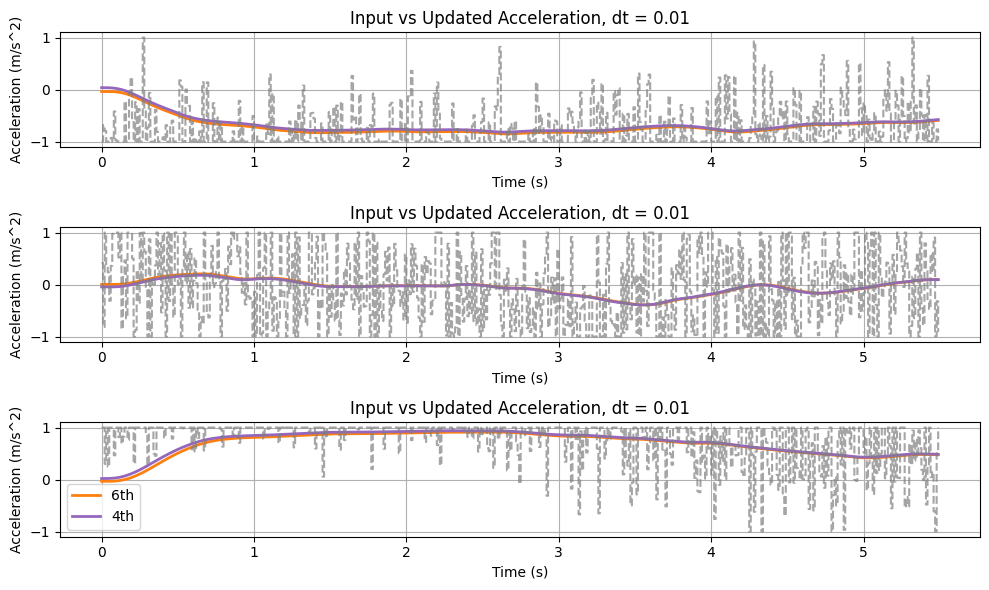

In [37]:
# # ACCELERATION
# # Plot step input acceleration and updated acceleration on the same figure for comparison
# plt.figure(figsize=(10, 5))
# # Plot the updated acceleration (response)
# plt.plot(time_array, accelerations[:, 0, 0], label='Updated Acceleration (a_x)', linewidth=2)
# plt.plot(time_array, accelerations[:,0,2], label='Updated Acceleration (a_z)', linewidth=1)
# # Plot the step input acceleration (input)
# plt.step(time_array, acc_commmanded[:, 0], label='Step Input Acceleration (a_x)', where='post', linestyle='--', alpha=0.7)

# plt.title('Step Input vs Updated Acceleration, dt = 0.01')
# plt.xlabel('Time (s)')
# plt.ylabel('Acceleration (m/s^2)')
# plt.legend()
# plt.grid(True)
# plt.show()

# # POSITION
# # Plot step input acceleration and updated acceleration on the same figure for comparison
# plt.figure(figsize=(10, 5))
# # Plot the updated acceleration (response)
# plt.plot(time_array, positions[:, 0, 0], label='Updated Position (p_x)', linewidth=2)
# plt.plot(time_array, positions[:, 0, 2], label='Updated Position (p_z)', linewidth=1)
# plt.plot(time_array, velocities[:, 0, 0], label='Updated Velocity (v_x)', linewidth=2)
# # Plot the step input acceleration (input)
# plt.step(time_array, acc_commmanded[:, 0], label='Step Input Acceleration (a_x)', where='post', linestyle='--', alpha=0.7)

# plt.title('Step Input vs Updated Position, dt = 0.01')
# plt.xlabel('Time (s)')
# plt.ylabel('States')
# plt.legend()
# plt.grid(True)
# plt.show()

## SUBPLOTS
## Plot states
# Separate plots for each acceleration component
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
# plt.plot(time_array, accelerations_2nd[:, 0, 0], label='Updated Acceleration 2nd (a_x)', linewidth=2, color ='tab:blue')
# plt.plot(time_array, accelerations_2nd_dc[:, 0, 0], label='Updated Acceleration 2nd_dc (a_x)', linewidth=2, color ='tab:red')
plt.plot(time_array, accelerations_6th[:, 0, 0], label='Updated Acceleration 6th (a_x)', linewidth=2, color ='tab:orange')
plt.plot(time_array, accelerations_4th[:, 0, 0], label='Updated Acceleration 4th (a_x)', linewidth=2, color ='tab:purple')
# Plot the step input acceleration (input)
plt.step(time_array, acc_commmanded[:, 0], label='Commanded Acceleration (a_x_c)', where='post', linestyle='--', alpha=0.7, color = 'tab:gray')
plt.title('Input vs Updated Acceleration, dt = 0.01')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
#plt.legend()
plt.grid(True)


# ay
plt.subplot(3, 1, 2)
# plt.plot(time_array, accelerations_2nd[:, 0, 1], label='Updated Acceleration 2nd (a_y)', linewidth=2, color ='tab:blue')
# plt.plot(time_array, accelerations_2nd_dc[:, 0, 1], label='Updated Acceleration 2nd_dc (a_y)', linewidth=2, color ='tab:red')
plt.plot(time_array, accelerations_6th[:, 0, 1], label='Updated Acceleration 6th (a_y)', linewidth=2, color ='tab:orange')
plt.plot(time_array, accelerations_4th[:, 0, 1], label='Updated Acceleration 4th (a_y)', linewidth=2, color ='tab:purple')
# Plot the step input acceleration (input)
plt.step(time_array, acc_commmanded[:, 1], label='Commanded Acceleration (a_y_c)', where='post', linestyle='--', alpha=0.7, color = 'tab:gray')
plt.title('Input vs Updated Acceleration, dt = 0.01')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
#plt.legend()
plt.grid(True)


# az
plt.subplot(3, 1, 3)
# plt.plot(time_array, accelerations_2nd[:, 0, 2], label=' 2nd ', linewidth=2, color ='tab:blue')
# plt.plot(time_array, accelerations_2nd_dc[:, 0, 2], label='2nd_dc ', linewidth=2, color ='tab:red')
plt.plot(time_array, accelerations_6th[:, 0, 2], label=' 6th ', linewidth=2, color ='tab:orange')
plt.plot(time_array, accelerations_4th[:, 0, 2], label=' 4th ', linewidth=2, color ='tab:purple')
# Plot the step input acceleration (input)
plt.step(time_array, acc_commmanded[:, 2], label='Commanded Acceleration (a_z_c)', where='post', linestyle='--', alpha=0.7, color = 'tab:gray')
plt.title('Input vs Updated Acceleration, dt = 0.01')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
# plt.legend(["2nd", "2nd_dc", "6th"])
plt.legend(["6th", "4th"])
plt.grid(True)


plt.tight_layout()
plt.show()



# Plot all state variables

Accelerations

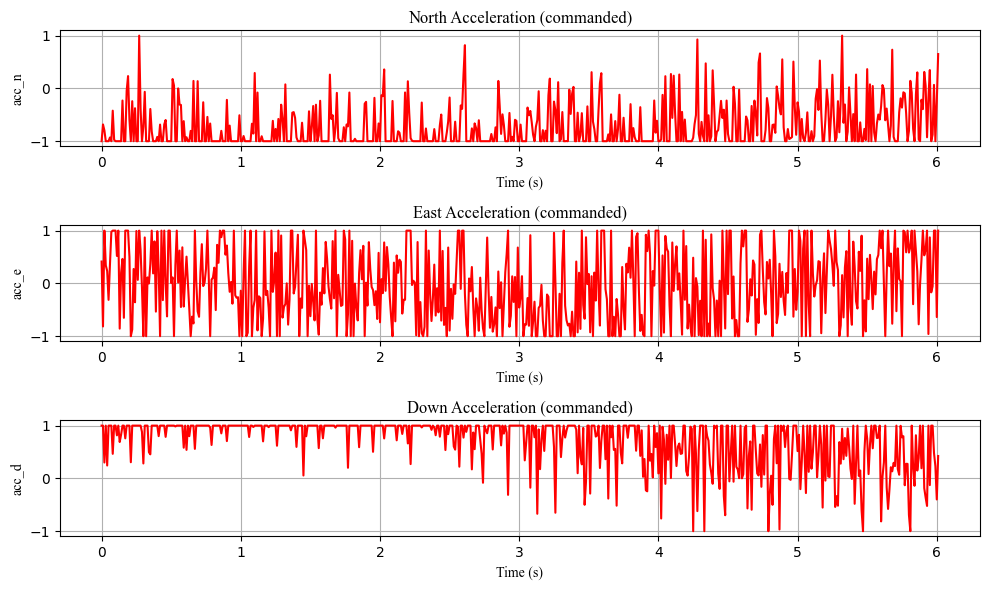

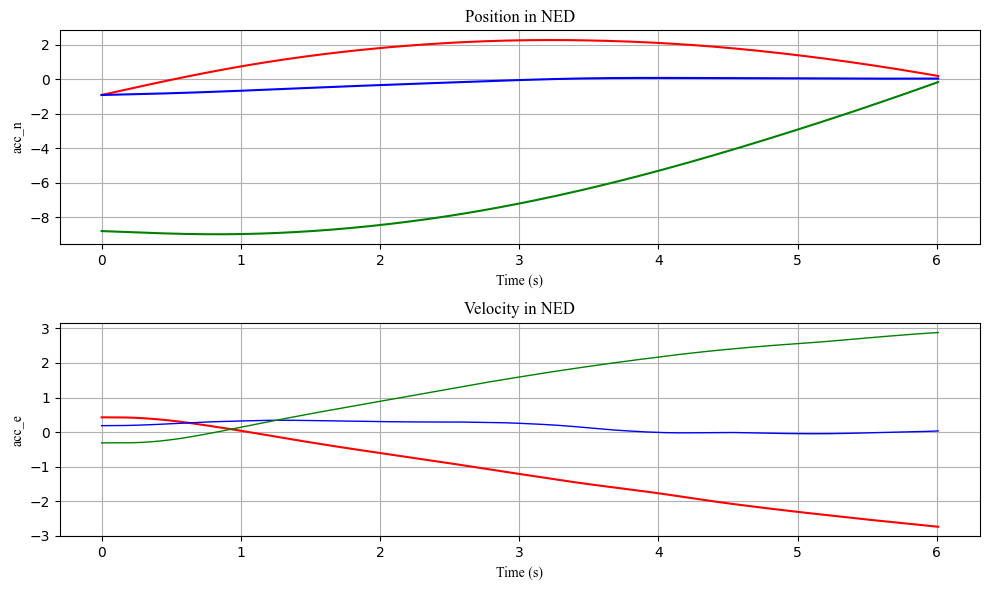

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This is important for 3d plotting 

ax_lim = 1
acc_n = action_list[:,0] 
acc_e = action_list[:,1]
acc_d = action_list[:,2] 


an = acc_ned_array[:,0]
ae = acc_ned_array[:,1]
ad = acc_ned_array[:,2]

pn = pos_ned_array[:,0]
pe = pos_ned_array[:,1]
pd = pos_ned_array[:,2]

vn = vel_ned_array[:,0]
ve = vel_ned_array[:,1]
vd = vel_ned_array[:,2]

# Create the time array
time = np.arange(0, len(acc_n)*dt , dt)


# Separate plots for each acceleration component
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(time, acc_n, 'r-', linewidth=1.5)
#plt.plot(time, an, 'r-', linewidth=1)
plt.title('North Acceleration (commanded)', fontname='Times New Roman', fontsize=12)
plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=10)
plt.ylabel('acc_n', fontname='Times New Roman', fontsize=10)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, acc_e, 'r-', linewidth=1.5)
#plt.plot(time, ae, 'b-', linewidth=1)
plt.title('East Acceleration (commanded)', fontname='Times New Roman', fontsize=12)
plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=10)
plt.ylabel('acc_e', fontname='Times New Roman', fontsize=10)
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, acc_d, 'r-', linewidth=1.5)
#plt.plot(time, ad, 'g-', linewidth=1)
plt.title('Down Acceleration (commanded)', fontname='Times New Roman', fontsize=12)
plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=10)
plt.ylabel('acc_d', fontname='Times New Roman', fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()



## Plot states
# Separate plots for each acceleration component
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(time, pn, 'r-', label='Updated Position (p_n)',  linewidth=1.5)
plt.plot(time, pe, 'b-', label='Updated Position (p_e)',  linewidth=1.5)
plt.plot(time, pd,'g-',  label='Updated Position (p_d)',  linewidth=1.5)
plt.title('Position in NED', fontname='Times New Roman', fontsize=12)
plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=10)
plt.ylabel('acc_n', fontname='Times New Roman', fontsize=10)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(time, vn, 'r-', label='Updated Position (v_n)', linewidth=1.5)
plt.plot(time, ve, 'b-', label='Updated Position (v_e)', linewidth=1)
plt.plot(time, vd, 'g-', label='Updated Position (v_d)', linewidth=1)
plt.title('Velocity in NED', fontname='Times New Roman', fontsize=12)
plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=10)
plt.ylabel('acc_e', fontname='Times New Roman', fontsize=10)
plt.grid(True)



plt.tight_layout()
plt.show()



Position

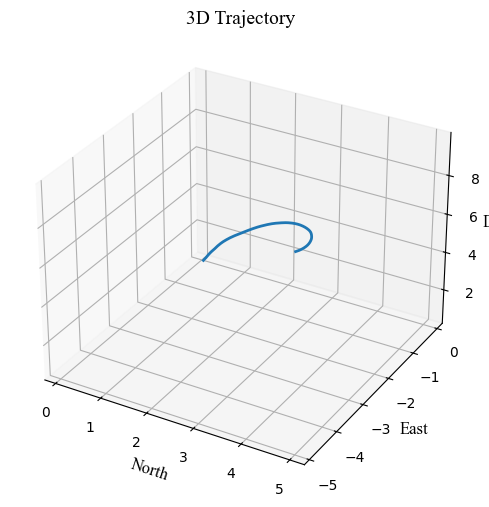

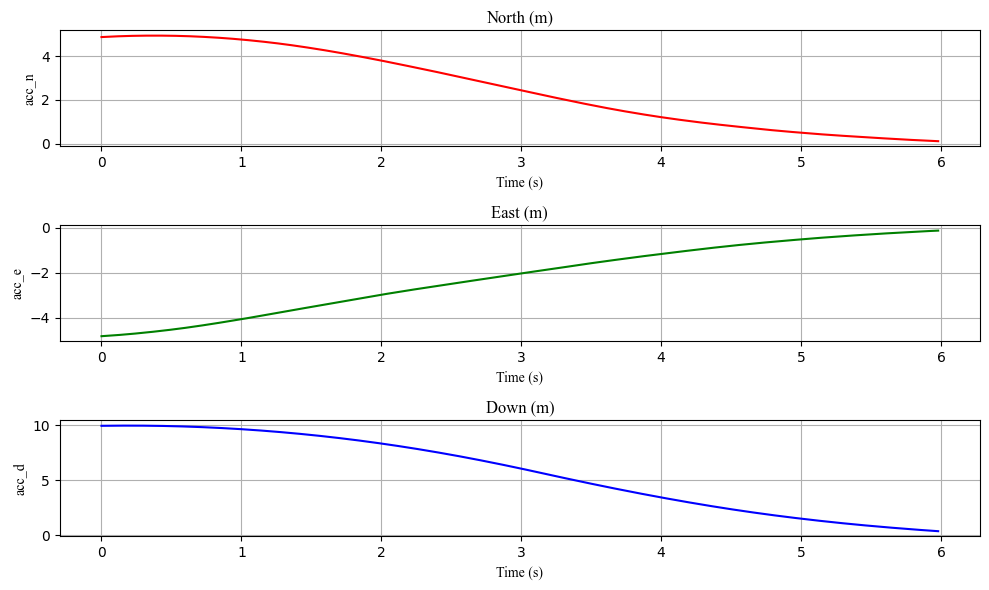

In [28]:
p_n = pos_ned_array[:,0]
p_e = pos_ned_array[:,1]
p_d = pos_ned_array[:,2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(p_n, p_e, -p_d, linewidth=2)  # Blue, with circles at data points
ax.set_xlabel('North', fontname='Times New Roman', fontsize=12)
ax.set_ylabel('East', fontname='Times New Roman', fontsize=12)
ax.set_zlabel('Down', fontname='Times New Roman', fontsize=12)
ax.set_title('3D Trajectory', fontname='Times New Roman', fontsize=14)
plt.show()

# Separate plots for each acceleration component
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(time, p_n, 'r-', linewidth=1.5)
plt.title('North (m)', fontname='Times New Roman', fontsize=12)
plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=10)
plt.ylabel('acc_n', fontname='Times New Roman', fontsize=10)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, p_e, 'g-', linewidth=1.5)
plt.title('East (m)', fontname='Times New Roman', fontsize=12)
plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=10)
plt.ylabel('acc_e', fontname='Times New Roman', fontsize=10)
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, -p_d, 'b-', linewidth=1.5)
plt.title('Down (m)', fontname='Times New Roman', fontsize=12)
plt.xlabel('Time (s)', fontname='Times New Roman', fontsize=10)
plt.ylabel('acc_d', fontname='Times New Roman', fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()



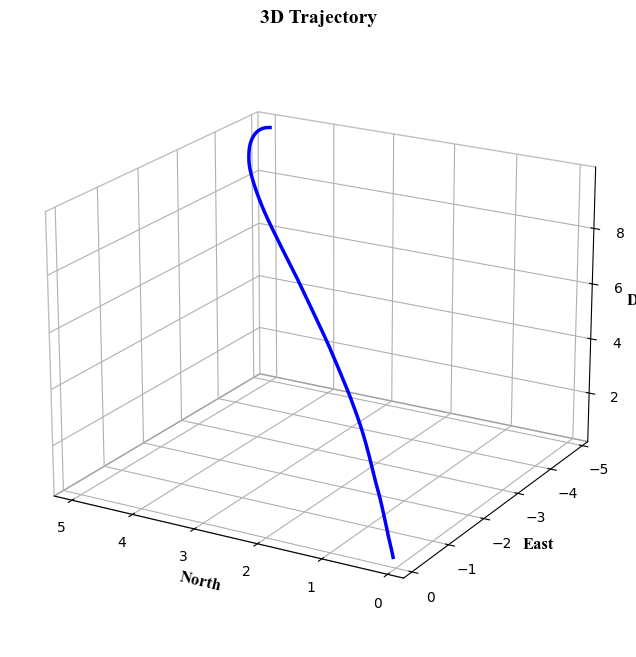

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Create a new figure and a 3D subplot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory with custom style
ax.plot(p_n, p_e, -p_d, color='blue', linewidth=2.5, linestyle='-', markersize=5)

# Set labels with custom font size and bold text
ax.set_xlabel('North', fontname='Times New Roman', fontsize=12, fontweight='bold')
ax.set_ylabel('East', fontname='Times New Roman', fontsize=12, fontweight='bold')
ax.set_zlabel('Down', fontname='Times New Roman', fontsize=12, fontweight='bold')
ax.set_title('3D Trajectory', fontname='Times New Roman', fontsize=14, fontweight='bold')

# Customize the grid and background
ax.grid(True)
ax.xaxis.pane.fill = False  # Left pane
ax.yaxis.pane.fill = False  # Right pane
ax.zaxis.pane.fill = False  # Bottom pane
ax.xaxis.pane.set_edgecolor('gray')
ax.yaxis.pane.set_edgecolor('gray')
ax.zaxis.pane.set_edgecolor('gray')

# Set the viewing angle for better visibility
ax.view_init(elev=20, azim=120)  # These angles need to be adjusted for the best view

# Optionally, save the figure with high quality
plt.savefig('3D_trajectory.png', dpi=300)

# Show the plot with interactive rotation
plt.show()


# Logging

In [18]:
test_env.max_steps = 10000
test_env.reset()

time = []
state_traj = []
action_traj = []

def run():
    actions, _ = model.predict(test_env.states, deterministic=False)
    states, rewards, dones, infos = test_env.step(actions)
    state_traj.append(test_env.world_states_drone[0].copy())
    # state_traj.append(test_env.world_states[0].copy())
    action_traj.append(actions[0].copy())
    time.append(test_env.step_counts[0]*test_env.dt)
        
    return test_env.render()

# stacked_states = np.stack([x0, y0, z0, vx0, vy0, vz0,ax0, ay0, az0 ]).T
animation_VSQP.view(run)

# make log dict
log_dict = {}
state_traj = np.array(state_traj)
action_traj = np.array(action_traj)

log_dict['t'] = time
log_dict['x'] = state_traj[:,0]
log_dict['y'] = state_traj[:,1]
log_dict['z'] = state_traj[:,2]
log_dict['vx'] = state_traj[:,3]
log_dict['vy'] = state_traj[:,4]
log_dict['vz'] = state_traj[:,5]
log_dict['ax'] = state_traj[:,6]
log_dict['ay'] = state_traj[:,7]
log_dict['az'] = state_traj[:,8]
log_dict['u1'] = (action_traj[:,0]+1)/2
log_dict['u2'] = (action_traj[:,1]+1)/2
log_dict['u3'] = (action_traj[:,2]+1)/2
log_dict['u'] = np.stack([log_dict['u1'], log_dict['u2'], log_dict['u3']], axis=1)

# save log dict to flight_data/simulation_logs
# make folder
name = 'VSQP_acc_V1'
folder = 'flight_data/simulation_logs'
if not os.path.exists(folder):
    os.makedirs(folder)
# save dict as npz
np.savez(folder + '/' + name, **log_dict)

# Plot the data

In [ ]:
# load the dict
log_dict_V1 = dict(np.load('flight_data/simulation_logs/VSQP_acc_V1.npz'))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting trajectory
ax.plot(log_dict['x'], log_dict['y'], -1*log_dict['z'], label='UAV Trajectory', marker='.')

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Trajectory and Landing Platform')
ax.legend()